<a href="https://colab.research.google.com/github/arny617/Others/blob/main/lda_topic_modelling_SEC10KDocs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b> Apply Topic Modelling (using LDA, NMF, TFIDF) on scraped SEC reports, to find topics discussed among all the reports </b>

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=52ab3c1faa6b95f9821fb50bfb902c100e8eb537f59fa8233d9e96db69eb784d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 69.1MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.9" 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-11-08 23:00:21--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.7MB/s    in 1.3s    

2020-11-08 23:00:22 (11.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
### LDA Mallet Model
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'



In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from bs4 import BeautifulSoup
import os
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pyarrow
import pickle
from tqdm import tqdm, tqdm_notebook
from tqdm import notebook
import joblib
%matplotlib inline

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/Colab Notebooks/NLP/"
os.chdir(ROOT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#os.chdir("../sec_10k_new2")
#os.chdir("sec_10q")
files_req = [x for x in os.listdir("./sec_10q")]

In [ ]:
files_req[0].split("_")[0]

'china'

In [ ]:
def clean_html(html_text):
    soup = BeautifulSoup(html_text)
    for script in soup(["script"]): 
        script.extract()
    fin_text = soup.get_text()
    fin_text = fin_text.replace("\n","").replace("\t","").replace("\xa0","").replace("\ufeff","")
    return(fin_text)

In [ ]:
doc_df = pd.DataFrame()
i = 0
for file in notebook.tqdm(files_req):
    path_ = os.path.join('sec_10q/',file)
    html_file = open(path_, 'r', encoding='utf-8',errors='ignore')
    html_body = html_file.read() 
    clean_text = clean_html(html_body)
    doc_df = doc_df.append(pd.Series(["doc_"+str(i),clean_text]),ignore_index=True)
    i +=1

In [ ]:
doc_df.columns = ["doc_name","text"]

In [ ]:
doc_df

,doc_name,text
0,doc_0,EDGAR Search ResultsHome | Latest Filings | Pr...
1,doc_1,.picker_wrapper.no_alpha .picker_alpha{display...
2,doc_2,10-Q1fmc20160930-10q.htmFORM 10-Q FOR QUARTERL...
3,doc_3,.picker_wrapper.no_alpha .picker_alpha{display...
4,doc_4,10-Q1king_10q.htmFORM 10-Qking_10q.htm UNITE...
5,doc_5,.picker_wrapper.no_alpha .picker_alpha{display...
6,doc_6,10-Q1v241195_10-q.htmQUARTERLY REPORTUnassocia...
7,doc_7,.picker_wrapper.no_alpha .picker_alpha{display...
8,doc_8,.picker_wrapper.no_alpha .picker_alpha{display...
9,doc_9,.picker_wrapper.no_alpha .picker_alpha{display...


In [ ]:
import re
# Convert to list
data = doc_df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \S
<input>:9: DeprecationWarning: invalid escape sequence \s
<input>:6: Dep

In [ ]:

joblib.dump(doc_df,"doc_df.pkl")

['doc_df.pkl']

### Text Pre-processing

Download required packages

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

NameError: ignored

In [ ]:
import nltk
from nltk.corpus import stopwords as sw
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
import gensim
from gensim.utils import simple_preprocess

In [ ]:
stopfile = open("StopWords_GenericLong.txt",'r',encoding='UTF-8')
stopw = stopfile.read()

In [ ]:
content_list = stopw.split("\n")

In [ ]:
content_list[:10]

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after']

In [ ]:
def clean_text(text_blob):
    """
    This function aims to perform a series of text processing tasks - 
    For each paragraph
        a)basic pre-processing and removal of punctuations
        b)perform POS tagiing
        c)remove stopwords, non alphabetical character sequences and proper nouns
    
    Input : Simple raw text corpus
    Output : list of processed text
    """
    stopwords = sw.words("english")
    stopwords.extend(content_list)
    ps = SnowballStemmer("english")
    #ps = PorterStemmer()
    para = ' '.join(simple_preprocess(text_blob,deacc = True)) #Basic preprocessing and removal of punctuations
    tagged_list = nltk.tag.pos_tag(para.split())
    fin_text_blob = []
    for word,tag in tagged_list:
        if((word.lower() not in stopwords) and (word.isalpha()) and (len(word) >= 3) and (tag != "NNP" and tag != "NNPS")):
            fin_text_blob.extend([ps.stem(word.lower())])
    return(fin_text_blob) #This function hence returns the original text blob, processed 

In [ ]:
text_list = []
for i in notebook.tqdm(range(doc_df.shape[0])):
    text_blob = clean_text(doc_df.text[i])
    text_list.extend([text_blob])

Create a bigram module

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [ ]:
stop_words.extend(content_list)
#stop_words.extend(["top","webkit","border","bottom","background","box","display","search","fact","content","solid","tag","leave","select","list","filter","color","deg",\
#                   "button","rgba","custom","leave","gradient","datum","highlight","set","block","red","save","hover","white","imag_linear","popup","pad"])

In [ ]:
import spacy

In [ ]:
import gensim
bigram = gensim.models.Phrases(text_list, min_count=8, threshold=20) #Generating bigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[text_list], threshold=20)  
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(text_list)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['late', 'file', 'previous', 'page', 'edgar', 'search', 'system', 'search', 'current', 'pagemail', 'address', 'unit', 'unit', 'structur', 'clay', 'productsst', 'end', 'issuer', 'filter', 'resultssearch', 'file', 'file', 'type', 'prior', 'yyyymmdd', 'ownership', 'result', 'page', 'entri', 'entri', 'entri', 'enter', 'film', 'brow', 'system', 'previous', 'pagemodifi']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=1, no_above=0.75)
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1)]]


In [ ]:
lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model1.print_topics())
doc_lda = lda_model1[corpus]

[(0,
  '0.024*"debt" + 0.015*"cash" + 0.014*"ship" + 0.014*"oper" + 0.013*"rate" + '
  '0.012*"share" + 0.011*"statement" + 0.011*"loss" + 0.010*"cost" + '
  '0.010*"facil"'),
 (1,
  '0.036*"share" + 0.014*"date" + 0.014*"interest" + 0.013*"due" + '
  '0.013*"loss" + 0.013*"warrant" + 0.011*"year" + 0.010*"expen" + '
  '0.010*"statement" + 0.010*"oper"'),
 (2,
  '0.038*"nextset_hoverov" + 0.001*"share" + 0.001*"oper" + 0.001*"debt" + '
  '0.001*"cost" + 0.001*"year" + 0.001*"statement" + 0.001*"expect" + '
  '0.001*"loss" + 0.001*"rate"'),
 (3,
  '0.025*"year" + 0.018*"cost" + 0.015*"net" + 0.014*"expen" + 0.014*"oper" + '
  '0.013*"loss" + 0.012*"septemb" + 0.012*"tax" + 0.011*"market" + '
  '0.010*"effect"')]


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model1, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.21638446240722

Coherence Score:  0.643184383258862


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025253 -0.080300       1        1  42.697568
3      0.068862 -0.023538       2        1  30.460087
1      0.072629  0.087575       3        1  26.737946
2     -0.166745  0.016263       4        1   0.104399, topic_info=           Term        Freq       Total Category  logprob  loglift
602       share  216.000000  216.000000  Default  30.0000  30.0000
959        ship   75.000000   75.000000  Default  29.0000  29.0000
981     warrant   41.000000   41.000000  Default  28.0000  28.0000
721        year  148.000000  148.000000  Default  27.0000  27.0000
1018        ccl   40.000000   40.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
374       limit    0.009077   55.403510   Topic4  -7.2398  -1.8520
47    agreement    0.009077   76.541738   Topic4  -7.2398  -2.1752
28      account    0.009077   56.685896   Topic4  -7.2398  -1.8749
571    restrict    0.009077   53.865117   Topic4  -7.2398  -1.8238
672       total    0.009077   67.010648   Topic4  -7.2398  -2.0422

[299 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
28        1  0.246975  account
28        2  0.335180  account
28        3  0.423386  account
33        1  0.100817      act
33        2  0.201634      act
...     ...       ...      ...
981       3  0.988391  warrant
835       3  0.877693  whichev
721       1  0.128092     year
721       2  0.626976     year
721       3  0.242700     year

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3876244602646706


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('year', 0.02413793103448276),
   ('net', 0.021289355322338832),
   ('cost', 0.020989505247376312),
   ('expen', 0.020689655172413793),
   ('share', 0.020239880059970013),
   ('due', 0.016341829085457272),
   ('loss', 0.013493253373313344),
   ('market', 0.013493253373313344),
   ('oper', 0.012893553223388306),
   ('effect', 0.012893553223388306)]),
 (1,
  [('debt', 0.03232323232323232),
   ('share', 0.018365472910927456),
   ('statement', 0.017447199265381085),
   ('rate', 0.017079889807162536),
   ('date', 0.01689623507805326),
   ('cash', 0.01652892561983471),
   ('oper', 0.01487603305785124),
   ('ship', 0.014692378328741965),
   ('expect', 0.012672176308539946),
   ('interest', 0.01248852157943067)])]


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=2)

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6084
Num Topics = 4  has Coherence Value of 0.4986
Num Topics = 6  has Coherence Value of 0.626
Num Topics = 8  has Coherence Value of 0.5964


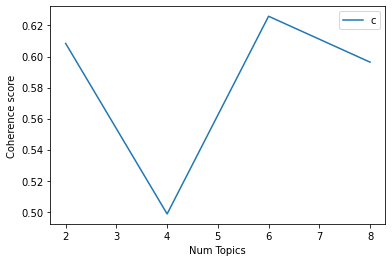

In [ ]:
# Show graph
limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
pprint(data[:1])

['EDGAR Search ResultsHome | Latest Filings | Previous Page EDGAR Search '
 'ResultsSEC Home »Search the Next-Generation EDGAR System »Company Search '
 '»Current PageMailing Address UNIT 2905, 29/F, METROPLAZA TOWER 2223 HING '
 'FONG ROAD, KWAI CHUNG, NTHONG KONG F8 00000 Business Address UNIT 2905, '
 '29/F, METROPLAZA TOWER 2223 HING FONG ROAD, KWAI CHUNG, NTHONG KONG F8 00000 '
 '86 (595) 8576 5051Antelope Enterprise Holdings Ltd CIK#: 0001470683 (see all '
 'company filings)SIC: 3250 - STRUCTURAL CLAY PRODUCTSState location: F8 | '
 'State of Inc.: D8 | Fiscal Year End: 1231formerly: China Ceramics Co., Ltd '
 '(filings through 2020-10-05)(Office of Manufacturing)Get insider '
 'transactions for this issuer.Filter ResultsSearch Within Files Filing '
 'Type:Prior to: (YYYYMMDD)Ownership?includeexcludeonlyLimit Results Per '
 'Page10 Entries 20 Entries 40 Entries 80 Entries 100 Entries Enter '
 'keywordsSearchFilingsFormatDescriptionFiling DateFile/Film '
 'Numberhttps://www.sec.go

In [ ]:
## Finding the dominant topic in each sentence

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)




In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model1, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9948,"debt, cash, ship, oper, rate, share, statement...",EDGAR Search ResultsHome | Latest Filings | Pr...
1,1,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
2,2,3.0,1.0000,"year, cost, net, expen, oper, loss, septemb, t...",10-Q1fmc20160930-10q.htmFORM 10-Q FOR QUARTERL...
3,3,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
4,4,1.0,0.9999,"share, date, interest, due, loss, warrant, yea...",10-Q1king_10q.htmFORM 10-Qking_10q.htm UNITED ...
5,5,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
6,6,1.0,0.9999,"share, date, interest, due, loss, warrant, yea...",10-Q1v241195_10-q.htmQUARTERLY REPORTUnassocia...
7,7,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
8,8,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
9,9,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...


In [ ]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9948,"debt, cash, ship, oper, rate, share, statement...",EDGAR Search ResultsHome | Latest Filings | Pr...
1,1,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
2,2,3.0,1.0000,"year, cost, net, expen, oper, loss, septemb, t...",10-Q1fmc20160930-10q.htmFORM 10-Q FOR QUARTERL...
3,3,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
4,4,1.0,0.9999,"share, date, interest, due, loss, warrant, yea...",10-Q1king_10q.htmFORM 10-Qking_10q.htm UNITED ...
5,5,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
6,6,1.0,0.9999,"share, date, interest, due, loss, warrant, yea...",10-Q1v241195_10-q.htmQUARTERLY REPORTUnassocia...
7,7,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
8,8,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...
9,9,2.0,0.9388,"nextset_hoverov, share, oper, debt, cost, year...",.picker_wrapper.no_alpha .picker_alpha{display...


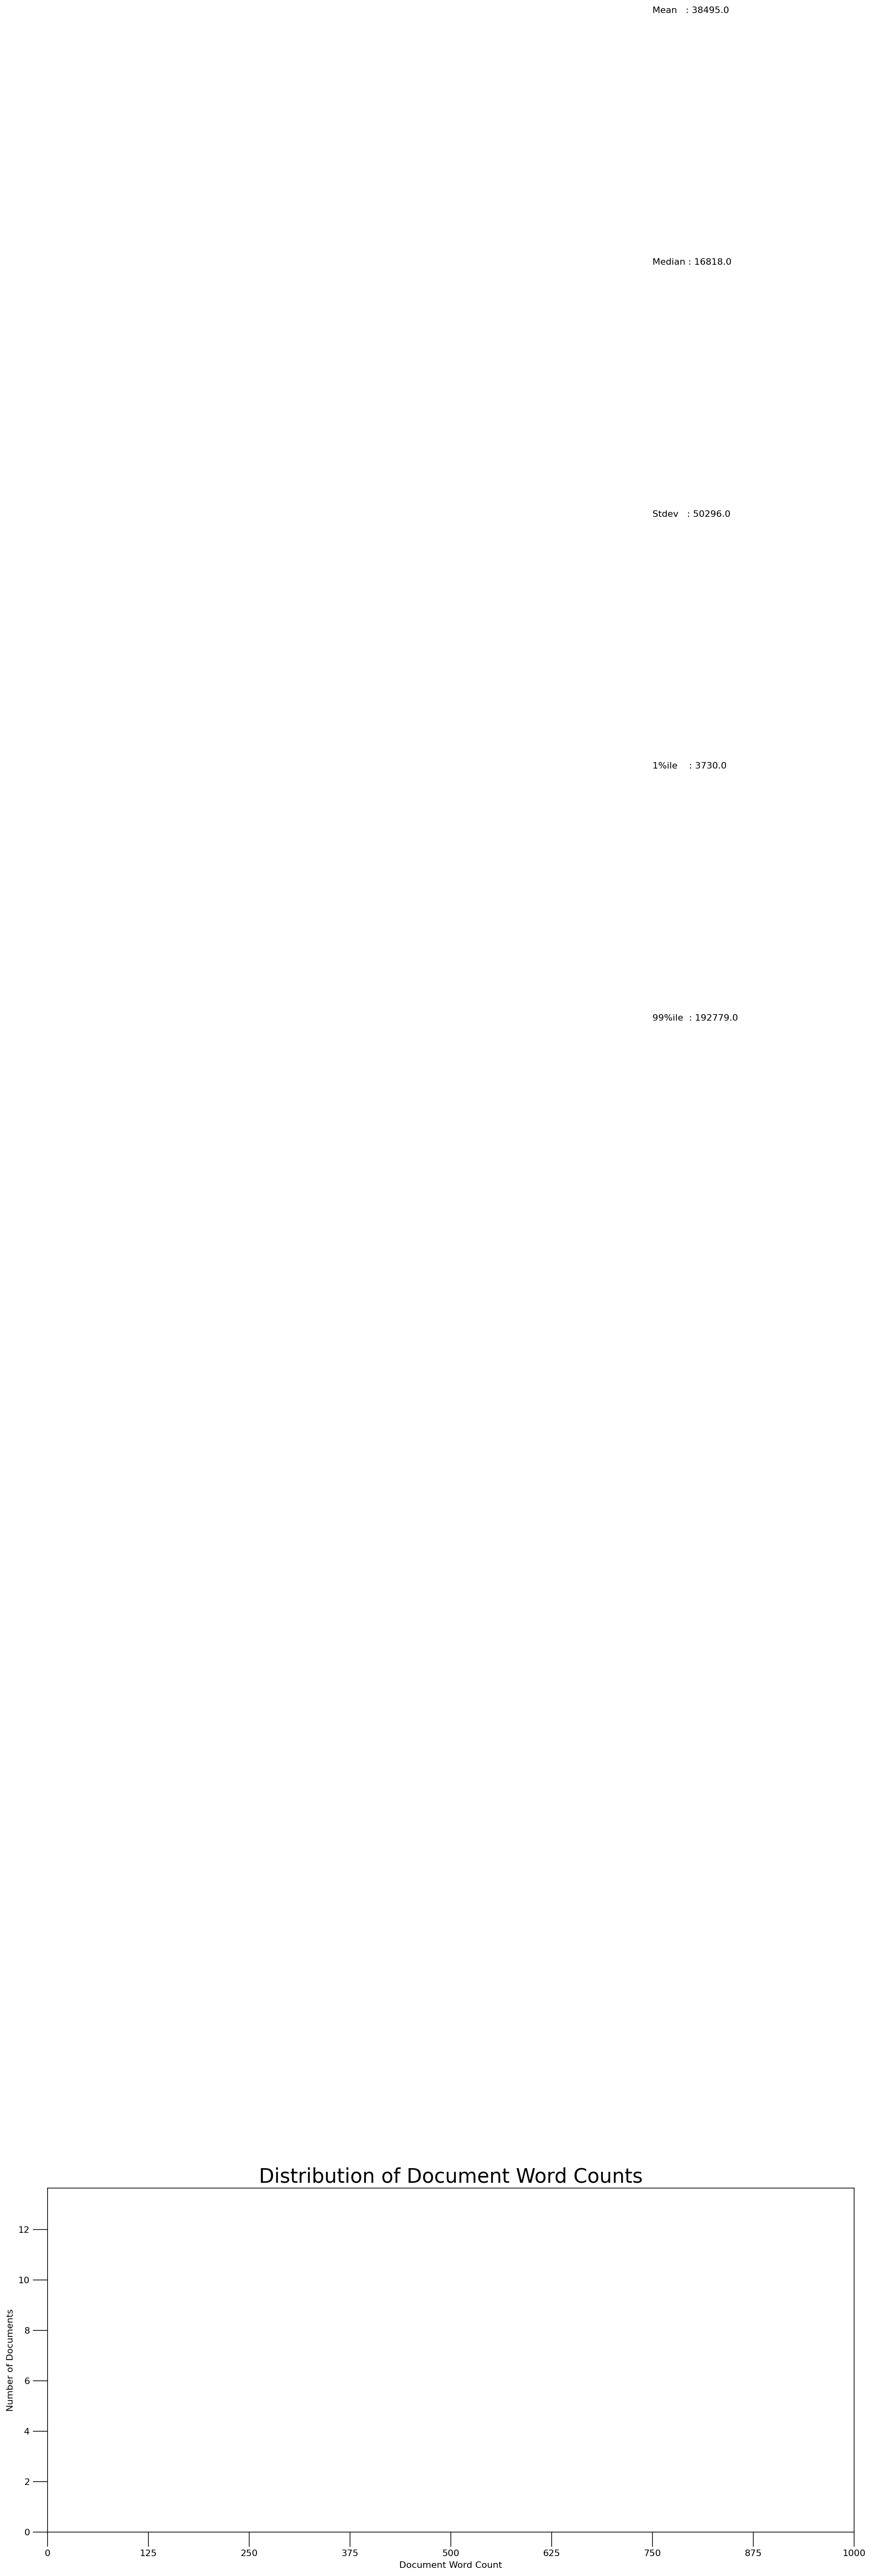

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


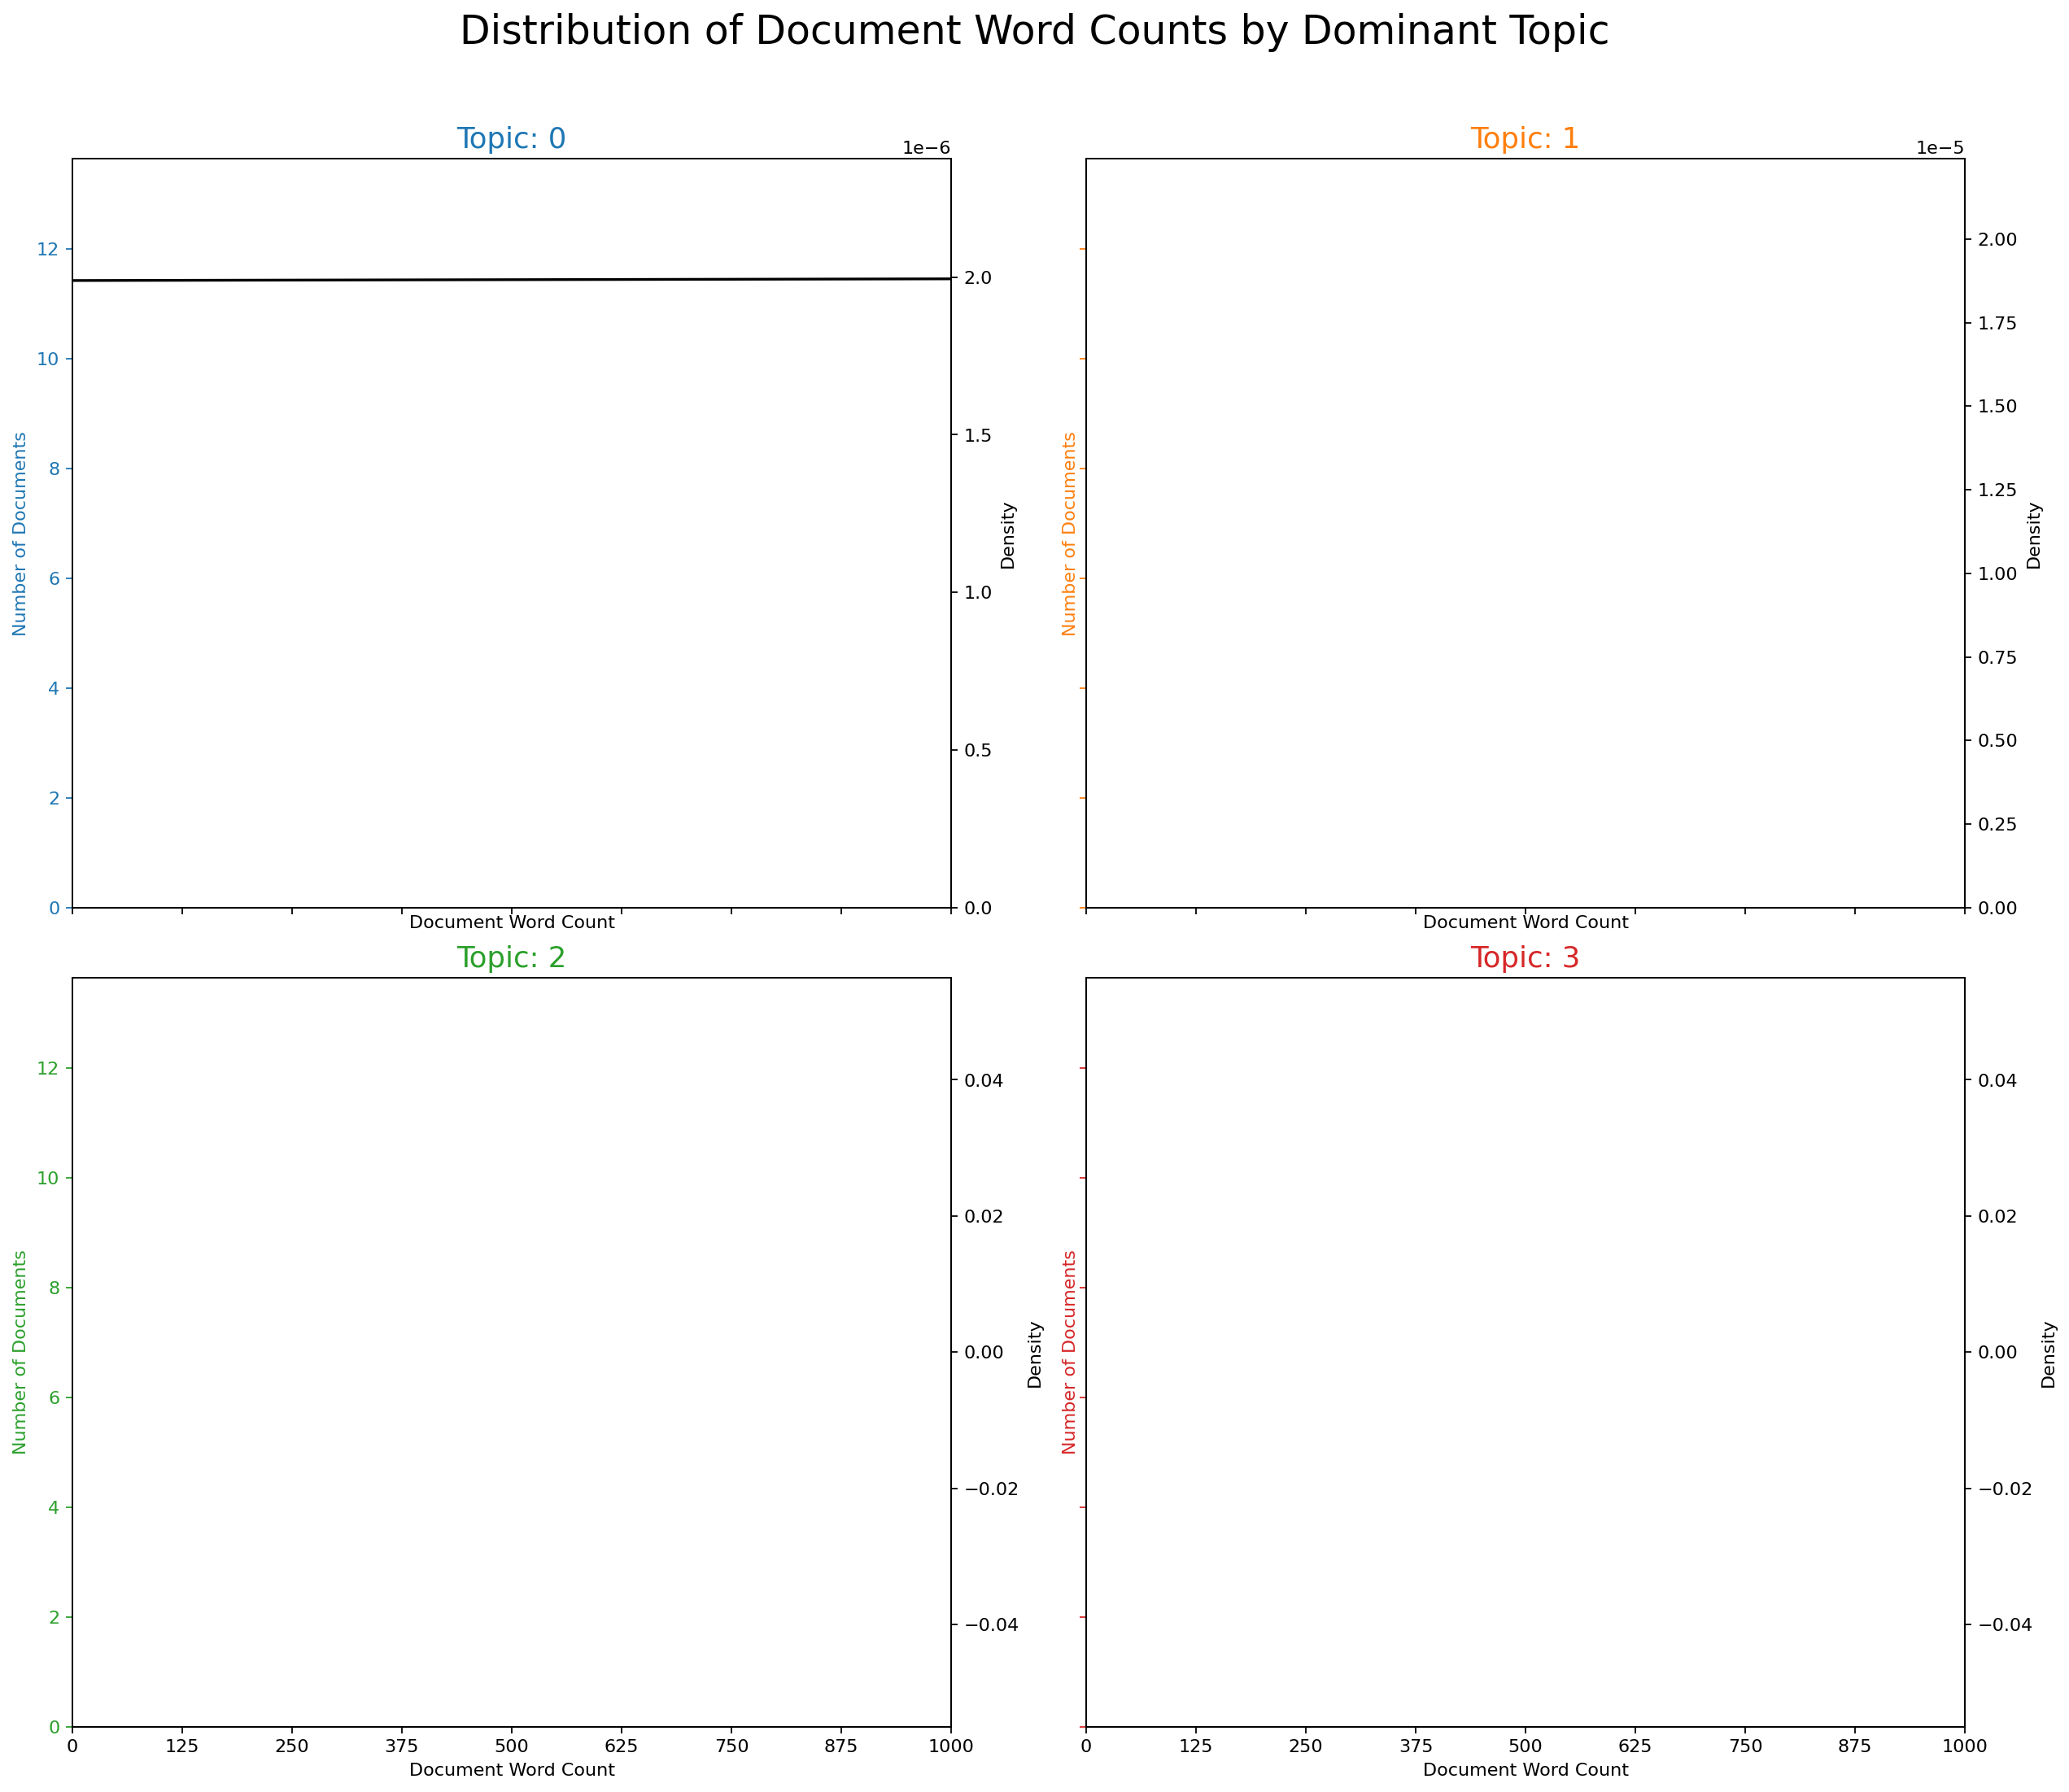

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

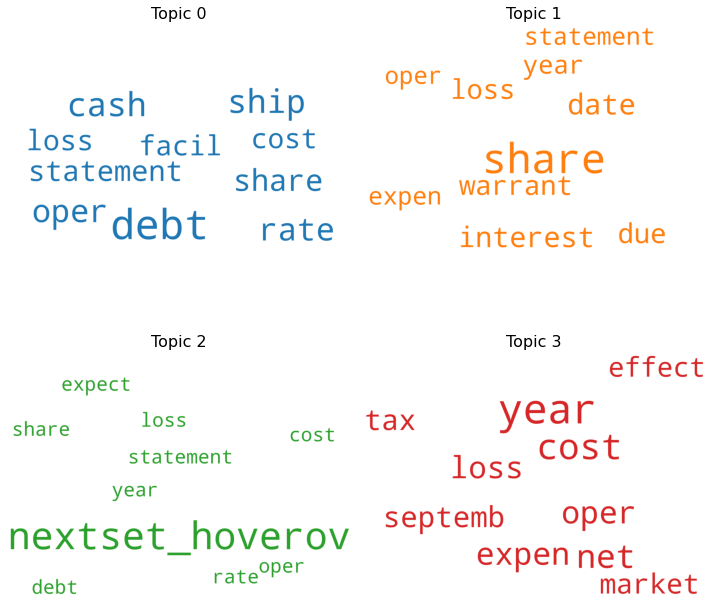

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
### Most discussed topics in a document

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model1, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model1.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

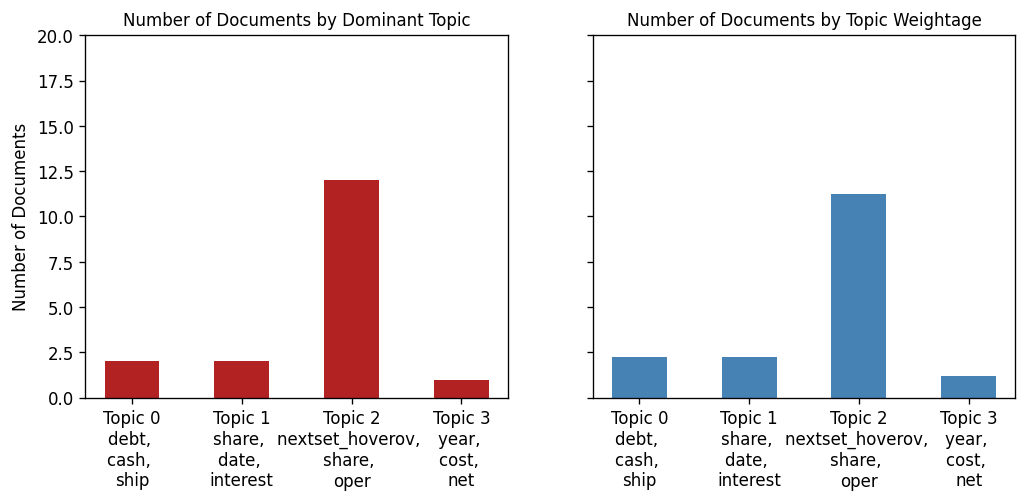

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 20)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model1[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 22.307848
[t-SNE] KL divergence after 1000 iterations: -6.225801


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [ ]:
# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2602,"year, cost, septemb, tax, loss, report, earn, ...",EDGAR Search ResultsHome | Latest Filings | Pr...
1,1,1.0,0.8860,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
2,2,4.0,0.5113,"year, cost, septemb, tax, loss, report, earn, ...",10-Q1fmc20160930-10q.htmFORM 10-Q FOR QUARTERL...
3,3,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
4,4,0.0,0.5952,"share, due, interest, date, loss, statement, e...",10-Q1king_10q.htmFORM 10-Qking_10q.htm UNITED ...
5,5,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
6,6,0.0,0.5841,"share, due, interest, date, loss, statement, e...",10-Q1v241195_10-q.htmQUARTERLY REPORTUnassocia...
7,7,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
8,8,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
9,9,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5952,"share, due, interest, date, loss, statement, e...",10-Q1king_10q.htmFORM 10-Qking_10q.htm UNITED ...
1,1.0,0.8864,"tag, leave, top, webkit, border, bottom, backg...",.picker_wrapper.no_alpha .picker_alpha{display...
2,2.0,0.4089,"debt, ship, rate, cash, facil, cost, ccl, stat...",.picker_wrapper.no_alpha .picker_alpha{display...
3,4.0,0.5113,"year, cost, septemb, tax, loss, report, earn, ...",10-Q1fmc20160930-10q.htmFORM 10-Q FOR QUARTERL...


In [ ]:
### Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"year, cost, septemb, tax, loss, report, earn, ...",2.0,0.1111
1.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",13.0,0.7222
2.0,4.0,"year, cost, septemb, tax, loss, report, earn, ...",1.0,0.0556
3.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",NaN,NaN
4.0,0.0,"share, due, interest, date, loss, statement, e...",2.0,0.1111
5.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",NaN,NaN
6.0,0.0,"share, due, interest, date, loss, statement, e...",NaN,NaN
7.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",NaN,NaN
8.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",NaN,NaN
9.0,1.0,"tag, leave, top, webkit, border, bottom, backg...",NaN,NaN


In [ ]:
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

In [ ]:
# data_words_bigrams = make_bigrams(text_list) #add bigrams to paragraph word lists

In [ ]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_words_bigrams)

# # Create Corpus
# texts = data_words_bigrams

# # Filter out words that occur less than 20 documents, or more than 50% of the documents.
# id2word.filter_extremes(no_below=4, no_above=0.5)

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

### Document Similarity using gensim tfidf

In [ ]:
#corpus
from gensim.models import TfidfModel
model = TfidfModel(corpus)
vector = model[corpus]

In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.similarities import MatrixSimilarity

In [ ]:
index = MatrixSimilarity(vector)

In [ ]:
### Example
index[model[corpus[4]]]

array([0.01316462, 0.00219281, 0.50253266, 0.00219281, 1.        ,
       0.00219281, 0.6086731 , 0.00219281, 0.00219281, 0.00219281,
       0.00219281, 0.00219281, 0.4871753 , 0.00219281, 0.00219281,
       0.00219281, 0.00219281, 0.00219281], dtype=float32)

In [ ]:
### Load test doc
doc_df2 = pd.DataFrame()
html_file = open(r"sec_10q/royal_caribbean_10q.html", 'r', encoding='utf-8',errors='ignore')
html_body = html_file.read() 
clean_text2 = clean_html(html_body)
doc_df2 = doc_df2.append(pd.Series(["doc_"+str(i),clean_text2]),ignore_index=True)
doc_df2.columns = ["doc_name","text"]

text_list2 = []
for i in notebook.tqdm(range(doc_df2.shape[0])):
    text_blob2 = clean_text(doc_df2.text[i])
    text_list2.extend([text_blob])

In [ ]:
doc_df2

,doc_name,text
0,doc_4.0,.picker_wrapper.no_alpha .picker_alpha{display...


In [ ]:
textArr2 = np.array(text_list2).ravel()

In [ ]:
text2 = " ".join(textArr2)

In [ ]:
corpus2 = [id2word.doc2bow(text) for text in text_list2]

In [ ]:
np.set_printoptions(precision=2,suppress=True)
print(index[model[corpus2]].ravel())

[0.04 0.5  0.08 0.5  0.07 0.5  0.06 0.5  0.5  0.5  0.5  0.5  0.1  0.5
 0.5  0.5  0.5  0.5 ]


### Document Similarity using sklearn tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=.65, min_df=4, stop_words='english')
transformed_documents = vectorizer.fit_transform(doc_df.text.values.astype('U'))

In [ ]:
transformed_documents_as_array = transformed_documents.toarray()
# use this line of code to verify that the numpy array represents the same number of documents that we have in the file list
len(transformed_documents_as_array)

18

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_tf_idf_query_similarity(vectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    return cosineSimilarities

In [ ]:
get_tf_idf_query_similarity(vectorizer, transformed_documents, text2)

array([0.08, 0.  , 0.11, 0.  , 0.06, 0.  , 0.07, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  ])

### LDA Modeling

We now deploy LDA model on the corpus, to arrive at a list of an optimum number of "topics" in the paragraphs. We use a multicore version of LDA to arrive at convergence faster

In [ ]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           chunksize=100,
                                           passes=50,
                                           alpha=0.001,
                                           eta='auto',
                                           minimum_probability = 0.3,
                                           minimum_phi_value=0.3,         
                                           decay=0.6,
                                           per_word_topics=True,workers=15)

In [ ]:
lda_model.print_topics(num_words=8)

[(0,
  '0.016*"share" + 0.015*"note" + 0.012*"debt" + 0.012*"oper" + 0.011*"year" + 0.011*"loss" + 0.010*"includ" + 0.010*"net"'),
 (1,
  '0.009*"file" + 0.009*"entri" + 0.007*"search" + 0.007*"previous" + 0.007*"unit" + 0.007*"system" + 0.007*"page" + 0.004*"result"'),
 (2,
  '0.001*"fact" + 0.001*"tag" + 0.001*"debt" + 0.001*"note" + 0.001*"oper" + 0.001*"share" + 0.001*"includ" + 0.001*"leave"'),
 (3,
  '0.001*"fact" + 0.001*"tag" + 0.001*"leave" + 0.001*"top" + 0.001*"webkit" + 0.001*"select" + 0.001*"debt" + 0.001*"border"'),
 (4,
  '0.099*"fact" + 0.057*"tag" + 0.041*"leave" + 0.039*"top" + 0.031*"webkit" + 0.026*"search" + 0.024*"border" + 0.024*"select"')]

<b> Coherence scores </b> are a very common metric for scoring the relevance of an LDA model. These scores are based on the idea of co-occurence of topic words in sliding windows on the raw text

In [ ]:
# Compute   Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  nan


/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.036585 -0.008682       1        1  36.223104
1      0.027124 -0.022633       2        1  35.200959
0      0.009461  0.031314       3        1  28.575937, topic_info=        Term        Freq       Total Category  logprob  loglift
160     gaap  253.000000  253.000000  Default  30.0000  30.0000
302  septemb  209.000000  209.000000  Default  29.0000  29.0000
107     debt  168.000000  168.000000  Default  28.0000  28.0000
18      year  210.000000  210.000000  Default  27.0000  27.0000
324      tax  156.000000  156.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
199   liabil   38.551777  135.127863   Topic3  -4.7327  -0.0016
287   requir   38.375937  145.566151   Topic3  -4.7373  -0.0806
272     rate   42.179441  188.807870   Topic3  -4.6428  -0.2462
55      base   33.905124  112.081257   Topic3  -4.8611   0.0569
143   expect   34.525552  121.808767   Topic3  -4.8430  -0.0081

[205 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
23        1  0.402605     account
23        2  0.277350     account
23        3  0.313137     account
27        1  0.693288    acquisit
27        2  0.126052    acquisit
...     ...       ...         ...
339       2  0.096793  unit_state
339       3  0.532362  unit_state
18        1  0.350776        year
18        2  0.170648        year
18        3  0.478762        year

[414 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

#### TF-IDF vectorization entire text corpus

In [ ]:
doc_df['Preprocessed'] = texts
doc_df['Preprocessed'] = doc_df.apply(lambda x: " ".join(x['Preprocessed']),axis=1)

In [ ]:
doc_df

,doc_name,text,Preprocessed,Topic_NMF
0,doc_0,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
1,doc_1,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
2,doc_2,cpandas.core.frameDataFrameq )q}q(X _dataqcp...,cpanda core framedataframeq core intern cpanda...,0
3,doc_3,",term,score0,subsea,236.454126129562071,fmc,17...",term score subsea fmc surfac crude backlog sch...,0
4,doc_4,",term,score0,merchandise,138.547339529040271,k...",term score merchandis kohl store retail conten...,0
5,doc_5,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
6,doc_6,",term,score0,cruise,441.50418863254171,ships,3...",term score cruis ship nclh norwegian cruis ncl...,0
7,doc_7,",term,score0,oneok,648.40154899590851,pipeline...",term score oneok pipelin ngl pipelin gather co...,0
8,doc_8,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
9,doc_9,",term,score0,xerox,846.06242005733931,fuji,221...",term score fuji fujifilm print conduent deason...,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,max_df=.65, min_df=5, stop_words='english')
tfidf_vect.fit(doc_df.Preprocessed.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.65, max_features=5000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [ ]:
doc_term_matrix = tfidf_vect.transform(doc_df.Preprocessed.values)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=3, random_state=42,max_iter=500)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=500,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
### Add column to original data that will store topic
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(10, 3)

In [ ]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['gainsboro', 'window', 'ordin', 'rotat', 'yellow', 'auto', 'dimens', 'shade', 'exampl', 'toinclud']


Top 10 words for topic #1:
['window', 'gainsboro', 'yellow', 'auto', 'dimens', 'exampl', 'rotat', 'shade', 'ordin', 'toinclud']


Top 10 words for topic #2:
['taxonomi', 'popup', 'gradient', 'incom', 'background', 'search', 'webkit', 'tabl', 'net', 'total']




### Non Negative Matrix Factorization for Topic Modelling

In [ ]:
#probability matrix that contains probabilities of all the words in the vocabulary for all the topics
from sklearn.decomposition import NMF

nmf = NMF(n_components=6, random_state=42,max_iter=500)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=500,
    n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['expens', 'cash', 'amend', 'liabil', 'asset', 'cost', 'incom', 'tabl', 'net', 'total']


Top 10 words for topic #1:
['viewer', 'width', 'deg', 'rgba', 'popup', 'taxonomi', 'gradient', 'background', 'search', 'webkit']


Top 10 words for topic #2:
['fluctuat', 'dakota', 'mark', 'launch', 'promulg', 'brand', 'conflict', 'kohl', 'novemb', 'decemb']


Top 10 words for topic #3:
['mbbl', 'kohl', 'roadrunn', 'carri', 'rais', 'north', 'popul', 'fluctuat', 'novemb', 'decemb']


Top 10 words for topic #4:
['rais', 'record', 'defend', 'convent', 'kohl', 'tabl', 'net', 'total', 'novemb', 'decemb']


Top 10 words for topic #5:
['roadrunn', 'compress', 'incom', 'septemb', 'octob', 'kohl', 'novemb', 'tabl', 'net', 'total']




In [ ]:
topic_values_nmf = nmf.transform(doc_term_matrix)
doc_df['Topic_NMF'] = topic_values_nmf.argmax(axis=1)
doc_df.head()

,doc_name,text,Preprocessed,Topic_NMF
0,doc_0,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
1,doc_1,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1
2,doc_2,cpandas.core.frameDataFrameq )q}q(X _dataqcp...,cpanda core framedataframeq core intern cpanda...,0
3,doc_3,",term,score0,subsea,236.454126129562071,fmc,17...",term score subsea fmc surfac crude backlog sch...,0
4,doc_4,",term,score0,merchandise,138.547339529040271,k...",term score merchandis kohl store retail conten...,0


In [ ]:
doc_df['Topic_tfidf'] = topic_values.argmax(axis=1)

In [ ]:
doc_df

,doc_name,text,Preprocessed,Topic_NMF,Topic_tfidf
0,doc_0,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1,2
1,doc_1,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1,2
2,doc_2,cpandas.core.frameDataFrameq )q}q(X _dataqcp...,cpanda core framedataframeq core intern cpanda...,0,2
3,doc_3,",term,score0,subsea,236.454126129562071,fmc,17...",term score subsea fmc surfac crude backlog sch...,0,2
4,doc_4,",term,score0,merchandise,138.547339529040271,k...",term score merchandis kohl store retail conten...,0,2
5,doc_5,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1,2
6,doc_6,",term,score0,cruise,441.50418863254171,ships,3...",term score cruis ship nclh norwegian cruis ncl...,0,2
7,doc_7,",term,score0,oneok,648.40154899590851,pipeline...",term score oneok pipelin ngl pipelin gather co...,0,2
8,doc_8,.picker_wrapper.no_alpha .picker_alpha{display...,display none posit absolut index opac display ...,1,2
9,doc_9,",term,score0,xerox,846.06242005733931,fuji,221...",term score fuji fujifilm print conduent deason...,0,2
